## Introduction

This ECG model is part of a larger multi-modal AI system designed for early detection of fetal abnormalities. The focus here is on classifying 4-channel abdominal ECG signals to detect fetal arrhythmias or abnormal heart activity.


%pip install wfdb  # For working with PhysioNet ECG datasets

In [1]:
!pip install wfdb


## Import core libraries

In [44]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from glob import glob
from collections import Counter

## Data Loading & Preprocessing

### Load Raw ECG and Annotations


This section loads raw ECG signals and associated annotations (labels) from the dataset.  
It includes:
- Reading `.dat` files (e.g., from PhysioNet format)
- Normalizing and formatting ECG signals
- Preparing inputs for model training or evaluation

In [ ]:

# ✅ SET-A path and file
base_path = r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\Dataset2_NonInvasive\set-a\set-a"
record_name = "a02"  # Pick any .hea/.dat/.fqrs triple available

# Load ECG signal (contains 4 abdominal channels)
record = wfdb.rdrecord(os.path.join(base_path, record_name))
ecg = record.p_signal  # shape: (60000, 4)
fs = record.fs  # sampling frequency (1000 Hz)

print(f"Loaded {record_name}: ECG shape = {ecg.shape}, Channels = {record.sig_name}")


Loaded a02: ECG shape = (60000, 4), Channels = ['AECG1', 'AECG2', 'AECG3', 'AECG4']


✅ Loaded 160 fetal QRS from .fqrs via wfdb.


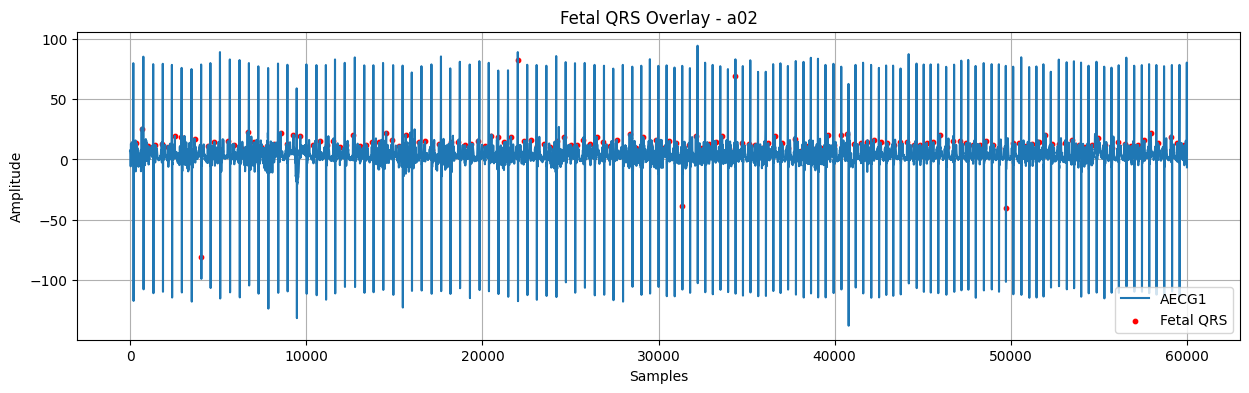

In [20]:
ann = wfdb.rdann(os.path.join(base_path, record_name), 'fqrs')

# Plot with annotations
fqrs_samples = ann.sample
print(f"✅ Loaded {len(fqrs_samples)} fetal QRS from .fqrs via wfdb.")

plt.figure(figsize=(15, 4))
plt.plot(ecg[:, 0], label="AECG1")
plt.scatter(fqrs_samples, ecg[fqrs_samples, 0], color='red', s=10, label="Fetal QRS")
plt.title(f"Fetal QRS Overlay - {record_name}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


## Bandpass Filtering for ECG Noise Removal


- Applies a bandpass filter to remove high-frequency noise and baseline drift from the ECG signal.  
- This enhances signal quality by preserving only the relevant frequency range (typically 0.5–40 Hz), which is important for accurate feature extraction and classification.

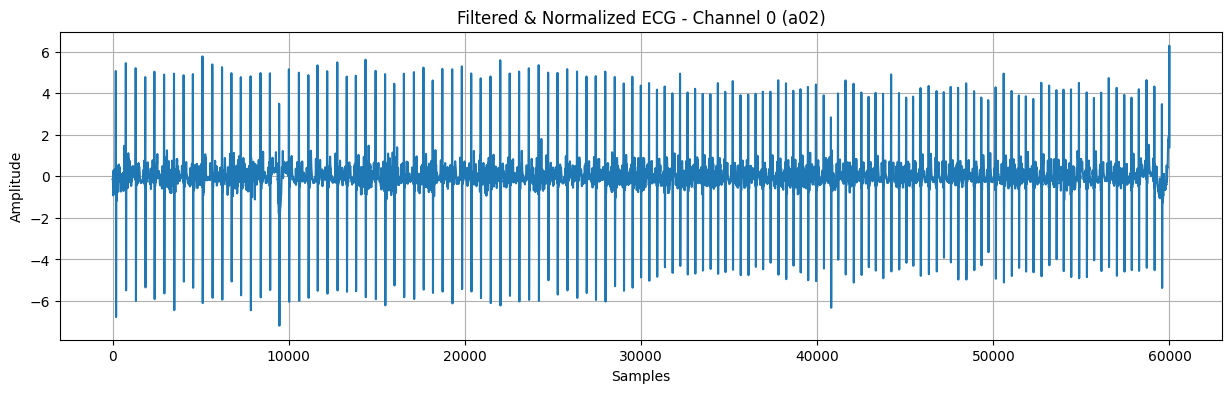

In [21]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut=0.5, highcut=45, fs=1000, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Apply filtering + normalization per channel
filtered_ecg = np.zeros_like(ecg)
for i in range(ecg.shape[1]):
    channel = bandpass_filter(ecg[:, i], lowcut=0.5, highcut=45, fs=fs)
    filtered_ecg[:, i] = (channel - np.mean(channel)) / np.std(channel)

# Plot filtered Channel 0
plt.figure(figsize=(15, 4))
plt.plot(filtered_ecg[:, 0])
plt.title(f"Filtered & Normalized ECG - Channel 0 ({record_name})")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [5]:
def bandpass_filter(signal, lowcut=0.5, highcut=45, fs=1000, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def label_from_qrs_count(qrs_count):
    return 0 if 11 <= qrs_count <= 16 else 1  # Normal HR = 110–160 bpm


## Load Dataset Paths

### Load Dataset from PhysioNet Set-A

Identifies available `.hea` records (header files) for ECG training data.


In [6]:
seta_path = r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\Dataset2_NonInvasive\set-a\set-a"
hea_files = sorted(glob.glob(os.path.join(seta_path, "*.hea")))
window_size = 6 * 1000  # 6 seconds

all_ecg_windows = []
all_labels = []

for hea_file in hea_files:
    record_name = os.path.basename(hea_file).replace(".hea", "")
    try:
        record = wfdb.rdrecord(os.path.join(seta_path, record_name))
        ann = wfdb.rdann(os.path.join(seta_path, record_name), 'fqrs')
        fqrs_samples = ann.sample

        ecg = record.p_signal
        fs = record.fs
        filtered = np.zeros_like(ecg)

        for i in range(ecg.shape[1]):
            f = bandpass_filter(ecg[:, i], 0.5, 45, fs)
            normed = (f - np.mean(f)) / np.std(f)
            filtered[:, i] = np.clip(normed, -5, 5)

        filtered = np.nan_to_num(filtered, nan=0.0, posinf=1.0, neginf=-1.0)
        n_windows = filtered.shape[0] // window_size

        for i in range(n_windows):
            start, end = i * window_size, (i + 1) * window_size
            if end > filtered.shape[0]:
                continue

            ecg_win = filtered[start:end]
            if ecg_win.shape[0] != window_size:
                continue

            qrs_in_win = [q for q in fqrs_samples if start <= q < end]
            label = label_from_qrs_count(len(qrs_in_win))

            all_ecg_windows.append(ecg_win)
            all_labels.append(label)
    except Exception as e:
        print(f"⚠️ Skipped {record_name}: {e}")

print(f"✅ Total: {len(all_ecg_windows)} | 🟢 Normal: {all_labels.count(0)} | 🔴 Abnormal: {all_labels.count(1)}")


✅ Total: 750 | 🟢 Normal: 693 | 🔴 Abnormal: 57


## Define PyTorch Dataset Class for ECG Windows

This custom PyTorch `Dataset` class processes multichannel fetal ECG data.  
It:
- Loads ECG windows (segments) from preprocessed data
- Applies optional filtering or normalization
- Returns input tensors `[channels, time]` and their corresponding labels for training or evaluation


In [7]:
class ECGWindowDataset(Dataset):
    def __init__(self, ecg_windows, labels):
        self.ecg_windows = ecg_windows
        self.labels = labels

    def __len__(self):
        return len(self.ecg_windows)

    def __getitem__(self, idx):
        x = torch.tensor(self.ecg_windows[idx].astype(np.float32)).permute(1, 0)  # (C, T)
        y = torch.tensor(self.labels[idx]).long()
        return x, y

dataset = ECGWindowDataset(all_ecg_windows, all_labels)

# Oversampling
labels = torch.tensor(all_labels)
class_counts = torch.bincount(labels)
weights = 1. / class_counts.float()
sample_weights = [weights[label] for label in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

loader = DataLoader(dataset, batch_size=8, sampler=sampler)




## Define CNN + Bi-LSTM Model for ECG Classification

Defines a hybrid deep learning model combining:  
- **1D CNN layers** to extract local waveform features (e.g., QRS complexes)  
- **Bi-directional LSTM** to capture temporal dependencies and rhythm patterns across time  
- **Fully connected layers** to output final classification (Normal or Abnormal)

This architecture is well-suited for sequential physiological signals like ECG.



In [8]:
class CNN_LSTM_ECG(nn.Module):
    def __init__(self, input_channels=4, num_classes=2):
        super(CNN_LSTM_ECG, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)              # (B, 64, T)
        x = x.permute(0, 2, 1)       # (B, T, 64)
        _, (hn, _) = self.lstm(x)    # (1, B, 64)
        return self.fc(hn[-1])       # (B, 2)


## Configure Device for Model Training

Automatically selects GPU if available, otherwise falls back to CPU.


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_LSTM_ECG().to(device)

weights = torch.tensor([1.0, class_counts[0] / (class_counts[1] + 1e-6)], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)



## Define Training Loop

Basic supervised training function for one epoch.

In [ ]:

def train_model(model, loader, criterion, optimizer, device, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            if torch.isnan(loss): continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        print(f"📈 Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {correct / total:.4f}")

    torch.save(model.state_dict(), "ecg_cnn_lstm_balanced.pth")
    print("✅ Model saved as ecg_cnn_lstm_balanced.pth")

train_model(model, loader, criterion, optimizer, device, epochs=30)


📈 Epoch 1/30 | Loss: 45.4939 | Accuracy: 0.5267
📈 Epoch 2/30 | Loss: 29.2732 | Accuracy: 0.5000
📈 Epoch 3/30 | Loss: 29.7315 | Accuracy: 0.4747
📈 Epoch 4/30 | Loss: 27.9374 | Accuracy: 0.5107
📈 Epoch 5/30 | Loss: 27.3106 | Accuracy: 0.5093
📈 Epoch 6/30 | Loss: 27.8248 | Accuracy: 0.5067
📈 Epoch 7/30 | Loss: 25.7939 | Accuracy: 0.6027
📈 Epoch 8/30 | Loss: 24.9744 | Accuracy: 0.6427
📈 Epoch 9/30 | Loss: 24.7148 | Accuracy: 0.7427
📈 Epoch 10/30 | Loss: 18.3697 | Accuracy: 0.7613
📈 Epoch 11/30 | Loss: 19.3603 | Accuracy: 0.7507
📈 Epoch 12/30 | Loss: 22.4905 | Accuracy: 0.7520
📈 Epoch 13/30 | Loss: 16.5363 | Accuracy: 0.8000
📈 Epoch 14/30 | Loss: 17.1160 | Accuracy: 0.8213
📈 Epoch 15/30 | Loss: 17.9365 | Accuracy: 0.8333
📈 Epoch 16/30 | Loss: 15.1507 | Accuracy: 0.8533
📈 Epoch 17/30 | Loss: 10.9866 | Accuracy: 0.8827
📈 Epoch 18/30 | Loss: 17.4451 | Accuracy: 0.8653
📈 Epoch 19/30 | Loss: 12.7990 | Accuracy: 0.8960
📈 Epoch 20/30 | Loss: 8.7855 | Accuracy: 0.9027
📈 Epoch 21/30 | Loss: 14.8939 

## Evaluate Model with Clinical Metrics

Prints accuracy, precision, recall, and F1 score — core clinical safety metrics.


📊 Evaluation Metrics:
✅ Accuracy  : 0.9827
✅ Precision : 0.9831
✅ Recall    : 0.9828
✅ F1 Score  : 0.9827


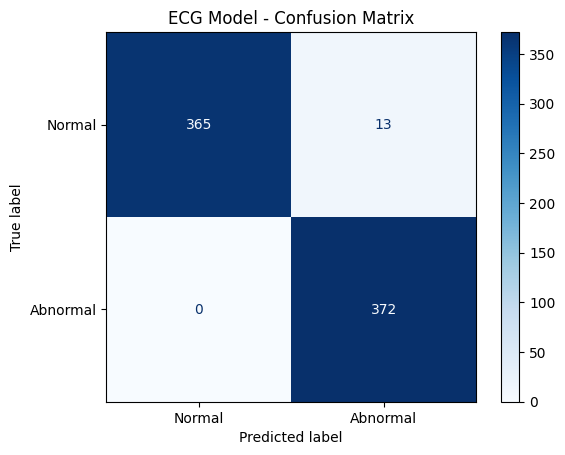

In [ ]:
model = CNN_LSTM_ECG().to(device)
model.load_state_dict(torch.load("ecg_cnn_lstm_balanced.pth"))
model.eval()

# Evaluation loop
all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# 🧮 Metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='macro')
recall = recall_score(all_targets, all_preds, average='macro')
f1 = f1_score(all_targets, all_preds, average='macro')

print("\n📊 Evaluation Metrics:")
print(f"✅ Accuracy  : {accuracy:.4f}")
print(f"✅ Precision : {precision:.4f}")
print(f"✅ Recall    : {recall:.4f}")
print(f"✅ F1 Score  : {f1:.4f}")

# 🧾 Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("ECG Model - Confusion Matrix")
plt.show()


## Save Trained Model Weights

Stores the trained model in `.pth` format for future inference or fine-tuning.


In [11]:
torch.save(model.state_dict(), "ecg_cnn_lstm_final.pth")


## Serialize Record Paths for Reproducibility

Saves dataset reference (file paths) using `pickle`.

In [12]:
import pickle

# Save windows
with open("ecg_windows.pkl", "wb") as f:
    pickle.dump(all_ecg_windows, f)

# Save labels
with open("ecg_labels.pkl", "wb") as f:
    pickle.dump(all_labels, f)

print("✅ ECG segments + labels saved as .pkl")


✅ ECG segments + labels saved as .pkl


In [34]:
def load_dat_segment(path_prefix, window_sec=10):
    import wfdb
    record = wfdb.rdrecord(path_prefix)
    ecg = record.p_signal.T[:4]  # [channels, time]
    fs = int(record.fs)

    center = ecg.shape[1] // 2
    half_window = (window_sec * fs) // 2
    segment = ecg[:, center - half_window : center + half_window]

    # Clean and normalize
    segment = np.nan_to_num(segment)
    segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-6)
    return segment.T  # return as [T, 4] for model input


## Locate Evaluation Data from Set-B

This step locates all `.hea` or `.dat` files in the Set-B directory using `glob`.  
These files represent the ECG records used for **unlabeled evaluation**, simulating real-world test data.



In [36]:
from glob import glob

set_b_dir = r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\Dataset2_NonInvasive\set-b\set-b"
dat_files = sorted(glob(f"{set_b_dir}/*.dat"))

print("🔍 ECG Predictions on Set-B:")
print("="*40)

for dat_path in dat_files:
    base = os.path.splitext(os.path.basename(dat_path))[0]
    try:
        segment = load_dat_segment(os.path.join(set_b_dir, base))  # shape: [10000, 4]
        x = torch.tensor(segment).float().permute(1, 0).unsqueeze(0).to(device)  # ✅ Correct shape: [1, 4, 10000]

        ecg_model.eval()
        with torch.no_grad():
            out = torch.softmax(ecg_model(x), dim=1)[0].cpu().numpy()
        
        label = "🟩 Normal" if out[0] > out[1] else "🟥 Abnormal"
        print(f"{base.upper()} → {label}  (Normal: {out[0]:.2f}, Abnormal: {out[1]:.2f})")
        
    except Exception as e:
        print(f"❌ Skipped {base}: {e}")


🔍 ECG Predictions on Set-B:
B00 → 🟩 Normal  (Normal: 0.94, Abnormal: 0.06)
B01 → 🟥 Abnormal  (Normal: 0.00, Abnormal: 1.00)
B02 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B03 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B04 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B05 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B06 → 🟩 Normal  (Normal: 0.93, Abnormal: 0.07)
B07 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B08 → 🟩 Normal  (Normal: 0.95, Abnormal: 0.05)
B09 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B10 → 🟥 Abnormal  (Normal: 0.00, Abnormal: 1.00)
B11 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B12 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B13 → 🟥 Abnormal  (Normal: 0.05, Abnormal: 0.95)
B14 → 🟥 Abnormal  (Normal: 0.01, Abnormal: 0.99)
B15 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B16 → 🟩 Normal  (Normal: 0.99, Abnormal: 0.01)
B17 → 🟥 Abnormal  (Normal: 0.07, Abnormal: 0.93)
B18 → 🟩 Normal  (Normal: 0.99, Abnormal: 0.01)
B19 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B20 → 🟩 Normal  (Norma

## Load Inference & Evaluation Utility Code 
Evaluates the trained ECG model on unseen records from the Set-B dataset.  
It calls a custom function to:
- Load and preprocess each record  
- Run inference  
- Print predictions and abnormality confidence scores per patient

Useful for validating the model on real-world, unlabeled ECG data.


In [ ]:
# ✅ Load ECG segment from .dat file
def load_dat_segment(path_prefix, window_sec=10):
    record = wfdb.rdrecord(path_prefix)
    ecg = record.p_signal.T[:4]  # [4, T]
    fs = int(record.fs)
    total_samples = ecg.shape[1]
    center = total_samples // 2
    half_window = (window_sec * fs) // 2
    segment = ecg[:, center - half_window: center + half_window]
    segment = np.nan_to_num(segment)
    segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-6)
    return segment.T  # [T, 4]

# ✅ Evaluate ECG model on Set-B
def evaluate_ecg_on_set_b(set_b_dir, ecg_model, device):
    dat_files = sorted(glob(os.path.join(set_b_dir, "*.dat")))
    all_preds = []
    all_probs = []

    print("🔍 ECG Predictions on Set-B")
    print("=" * 40)

    for dat_path in dat_files:
        base = os.path.splitext(os.path.basename(dat_path))[0]
        try:
            segment = load_dat_segment(os.path.join(set_b_dir, base))
            x = torch.tensor(segment).float().permute(1, 0).unsqueeze(0).to(device)  # [1, 4, T]

            ecg_model.eval()
            with torch.no_grad():
                prob = torch.softmax(ecg_model(x), dim=1).cpu().numpy().flatten()

            label = "🟩 Normal" if prob[0] > prob[1] else "🟥 Abnormal"
            print(f"{base.upper()} → {label}  (Normal: {prob[0]:.2f}, Abnormal: {prob[1]:.2f})")

            all_preds.append(np.argmax(prob))
            all_probs.append(prob)

        except Exception as e:
            print(f"❌ Skipped {base}: {e}")

    # Summary
    total = len(all_preds)
    if total == 0:
        print("⚠️ No valid ECG predictions were made. Check input files and model.")
        return

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    dist = Counter(all_preds)

    print("\n📊 Prediction Distribution on Set-B:")
    print(f"🟩 Normal    : {dist[0]}  ({dist[0] / total:.2%})")
    print(f"🟥 Abnormal  : {dist[1]}  ({dist[1] / total:.2%})")

    normal_conf = all_probs[all_preds == 0, 0]
    abnormal_conf = all_probs[all_preds == 1, 1]

    print(f"\n🔐 Confidence Stats:")
    if len(normal_conf):
        print(f"🟩 Normal:   {normal_conf.mean():.3f} ± {normal_conf.std():.3f}")
    if len(abnormal_conf):
        print(f"🟥 Abnormal: {abnormal_conf.mean():.3f} ± {abnormal_conf.std():.3f}")

    plt.hist(all_probs[:, 1], bins=20, color="#e63946", alpha=0.7)
    plt.title("Abnormal Probability Distribution (Set-B)")
    plt.xlabel("Abnormal Score")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


🔍 ECG Predictions on Set-B
B00 → 🟩 Normal  (Normal: 0.94, Abnormal: 0.06)
B01 → 🟥 Abnormal  (Normal: 0.00, Abnormal: 1.00)
B02 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B03 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B04 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B05 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B06 → 🟩 Normal  (Normal: 0.93, Abnormal: 0.07)
B07 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B08 → 🟩 Normal  (Normal: 0.95, Abnormal: 0.05)
B09 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B10 → 🟥 Abnormal  (Normal: 0.00, Abnormal: 1.00)
B11 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B12 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B13 → 🟥 Abnormal  (Normal: 0.05, Abnormal: 0.95)
B14 → 🟥 Abnormal  (Normal: 0.01, Abnormal: 0.99)
B15 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B16 → 🟩 Normal  (Normal: 0.99, Abnormal: 0.01)
B17 → 🟥 Abnormal  (Normal: 0.07, Abnormal: 0.93)
B18 → 🟩 Normal  (Normal: 0.99, Abnormal: 0.01)
B19 → 🟩 Normal  (Normal: 1.00, Abnormal: 0.00)
B20 → 🟩 Normal  (Normal

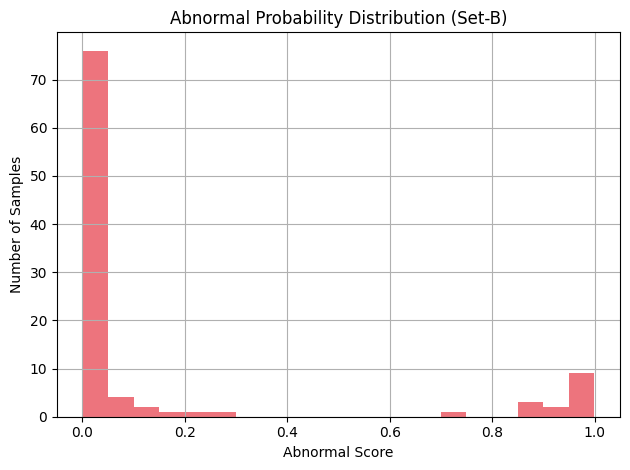

In [41]:
evaluate_ecg_on_set_b(
    set_b_dir=r"C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\ECG\Dataset2_NonInvasive\set-b\set-b",
    ecg_model=ecg_model,
    device=device
)
